In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive/TrafficCamAI

/content/gdrive/.shortcut-targets-by-id/1DWSLGFdo1Vf_Lkrxo_kcLxMrUOHlNpNf/TrafficCamAI


In [ ]:
!unzip -qq train.zip

replace train/crash/T2PeqBcJn3E0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train/crash/V17rwsM9ELw9.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace train/crash/V17rwsM9ELw9.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [ ]:
!unzip -qq val.zip

In [ ]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil


In [ ]:
!pip install keras_efficientnets
!pip install keras_applications
import keras_efficientnets
import pandas as pd
import numpy as np
import os

     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      horizontal_flip=True,
      )

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
target_size = (224, 224, 3)
batch_size = 64
train_generator = train_datagen.flow_from_directory(
        "train", 
        target_size=target_size[:2],  
        batch_size=batch_size,
        class_mode='binary',
      color_mode="rgb")

validation_generator = test_datagen.flow_from_directory(
        "val",
        target_size=target_size[:2],
        batch_size=batch_size,
        class_mode='binary',
      color_mode="rgb")

Found 1957 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [ ]:
effnet = keras_efficientnets.EfficientNetB0(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False
)
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)


In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam

def build_model():
    model = Sequential()
    model.add(effnet)
    # model.add(GlobalAveragePooling2D())
    model.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model2 = build_model()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 7, 7, 1280)        4049564   
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 32)          40992     
_________________________________________________________________
batch_normalization_99 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,090,717
Trainable params: 4,048,637
Non-trainable params: 42,080
_______________________________________

In [ ]:
results = model2.fit(
    train_generator,
    epochs=10,
    validation_data = validation_generator,
    batch_size=batch_size,
    callbacks=[early_stopper],
    verbose=1
)

Epoch 1/10
31/31 [==============================] - 31s 996ms/step - loss: 1.0945 - accuracy: 0.8825 - val_loss: 1.1360 - val_accuracy: 0.7944
Epoch 2/10
31/31 [==============================] - 31s 980ms/step - loss: 1.0703 - accuracy: 0.9024 - val_loss: 1.0924 - val_accuracy: 0.8167
Epoch 3/10
31/31 [==============================] - 31s 980ms/step - loss: 1.0460 - accuracy: 0.9172 - val_loss: 1.0591 - val_accuracy: 0.8389
Epoch 4/10
31/31 [==============================] - 31s 974ms/step - loss: 1.0207 - accuracy: 0.9244 - val_loss: 1.0160 - val_accuracy: 0.8500
Epoch 5/10
31/31 [==============================] - 31s 976ms/step - loss: 0.9961 - accuracy: 0.9310 - val_loss: 0.9762 - val_accuracy: 0.8500
Epoch 6/10
31/31 [==============================] - 31s 981ms/step - loss: 0.9743 - accuracy: 0.9366 - val_loss: 0.9473 - val_accuracy: 0.8500
Epoch 7/10
31/31 [==============================] - 31s 973ms/step - loss: 0.9538 - accuracy: 0.9397 - val_loss: 0.9244 - val_accuracy: 0.8500

In [ ]:
model2.save("BestModel.h5")

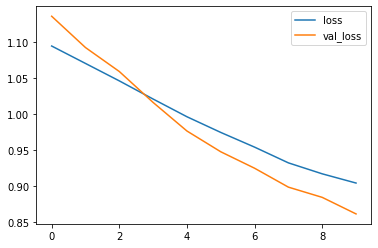

Ending Loss: 0.8608404994010925


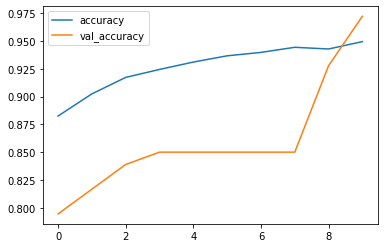

Ending Accuracy: 97.22222089767456


In [ ]:
losses = pd.DataFrame(results.history)
losses[['loss', 'val_loss']].plot()
plt.show()
print("Ending Loss:", losses['val_loss'][len(losses['val_loss'])-1])
# graph training and validation accuracy
losses[['accuracy', 'val_accuracy']].plot()
plt.show()
print("Ending Accuracy:", 100*losses['val_accuracy'][len(losses['val_accuracy'])-1])

In [ ]:
import json

# lets assume `model` is main model 
model_json = model2.to_json()
with open("model_in_json.json", "w") as json_file:
    json.dump(model_json, json_file)

model2.save("model_weights.h5")

In [ ]:
from keras.models import load_model
model3 = load_model('model_weights.h5')

In [ ]:
5


5